# Exploration of the Apple-news-data

In [194]:
import os
from dotenv import load_dotenv

load_dotenv()

my_key = os.getenv("alphavantage_key")

In [195]:
import pandas as pd

All relevant parameters for the API call.
`tickers` -> targeted company
`time_from` -> get only data older than specified time (format: YYYYMMDDTHHMM)
`time_to` -> get data published before specified time (format: YYYYMMDDTHHMM)
`sort` -> how to sort the result
`limit` -> number of entries returned, default is 50

### Important Information
The API returns no values for the time before March and for October (2022)

## Get 200 most relevant news for every month.

In [ ]:
days_of_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
time_limits = []
for i in range(1,13):
      month = f'{i}' if i/10>1 else f'0{i}' #two-digit month
      time_limits.append(f'2022{month}01T0101') # add start of month
      time_limits.append(f'2022{month}{days_of_month[i-1]}T2359')

In [ ]:
import requests

def get_news_by_month(month: int):
      assert month >= 1 & month <= 12
      tickers = 'AAPL'
      time_from = time_limits[2*(month-1)]
      time_to = time_limits[2*(month-1) + 1]
      sort = 'RELEVANCE'
      limit = 200

      url = 'https://www.alphavantage.co/query?' \
            'function=NEWS_SENTIMENT&' \
            f'tickers={tickers}&' \
            f'time_from={time_from}&' \
            f'time_to={time_to}&' \
            f'sort={sort}&' \
            f'limit={limit}&' \
            f'apikey={my_key}'
      r = requests.get(url)
      data = r.json()
      return pd.DataFrame(data['feed'])

In [ ]:
df = pd.DataFrame()

Run the first cell with all 5 API calls available. Wait at least one minute and run the second one.

In [ ]:
for i in range(3, 8):
      df_month = get_news_by_month(i)
      df = df.concat(df_month ,ignore_index=True)

In [ ]:
for i in range(8, 13):
      if i == 10:
            # there is no data for this month
            continue
      df_month = get_news_by_month(i)
      df = df.concat(df_month ,ignore_index=True)

Safe json to file for easier access

In [312]:
from dasai.helpers import get_raw_data_path

raw_data_path = get_raw_data_path()
raw_data_path.mkdir(parents=True, exist_ok=True)

df.to_json(raw_data_path / 'aapl_news.json')

Load data from file

In [313]:
df = pd.read_json(raw_data_path / 'aapl_news.json')

## Clean the data
### I. Transform the custom date-format-string to a real date

In [299]:
def clean_date(df):
      df['time_published'] = pd.to_datetime(df['time_published'], format='%Y%m%dT%H%M%S')
      return df

In [300]:
df = clean_date(df)

### II. Keep only interesting columns

In [301]:
df = df[['time_published', 'source', 'category_within_source', 'overall_sentiment_score', 'ticker_sentiment']]

### III. Remove all ticker details despite the relevant AAPL one
(within the column named ticker_sentiment)

first flatten

In [302]:
def flatten_nested_json_df(df):
    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

In [303]:
df = flatten_nested_json_df(df)
df = df.set_index('index')

original shape: (1800, 6)
original columns: Index(['index', 'time_published', 'source', 'category_within_source',
       'overall_sentiment_score', 'ticker_sentiment'],
      dtype='object')
lists: ['ticker_sentiment'], dicts: []
exploding: ticker_sentiment
lists: [], dicts: ['ticker_sentiment']
flattening: ticker_sentiment
lists: [], dicts: []
final shape: (10774, 9)
final columns: Index(['index', 'time_published', 'source', 'category_within_source',
       'overall_sentiment_score', 'ticker_sentiment.ticker',
       'ticker_sentiment.relevance_score',
       'ticker_sentiment.ticker_sentiment_score',
       'ticker_sentiment.ticker_sentiment_label'],
      dtype='object')


keep only the entries with the relevant ticker and remove ticker column (contains AAPL only)

In [304]:
df = df.query('`ticker_sentiment.ticker` == "AAPL"')

In [305]:
df = df.drop(['ticker_sentiment.ticker', 'ticker_sentiment.ticker_sentiment_label'], axis=1)

### Rename columns

In [306]:
df = df.rename(columns= {
    'category_within_source':'category',
    'ticker_sentiment.relevance_score':'relevance_score_aapl',
    'ticker_sentiment.ticker_sentiment_score':'sentiment_score_aapl',
})

In [319]:
df.columns

Index(['time_published', 'source', 'category', 'overall_sentiment_score',
       'relevance_score_aapl', 'sentiment_score_aapl'],
      dtype='object')

### Set correct dtypes

In [327]:
df['category'] = df['category'].astype('category')
df['relevance_score_aapl'] = df['relevance_score_aapl'].astype('float64')
df['sentiment_score_aapl'] = df['sentiment_score_aapl'].astype('float64')

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time_published           1800 non-null   datetime64[ns]
 1   source                   1800 non-null   object        
 2   category                 1800 non-null   category      
 3   overall_sentiment_score  1800 non-null   float64       
 4   relevance_score_aapl     1800 non-null   float64       
 5   sentiment_score_aapl     1800 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(3), object(1)
memory usage: 86.8+ KB


In [329]:
from dasai.helpers import get_tidy_data_path

tidy_data_path = get_tidy_data_path()
tidy_data_path.mkdir(parents=True, exist_ok=True)

df.to_parquet(tidy_data_path / 'aapl_news.parquet')

In [330]:
df = pd.read_parquet(tidy_data_path / 'aapl_news.parquet')

array([[<AxesSubplot: title={'center': 'overall_sentiment_score'}>,
        <AxesSubplot: title={'center': 'sentiment_score_aapl'}>],
       [<AxesSubplot: title={'center': 'relevance_score_aapl'}>,
        <AxesSubplot: >]], dtype=object)

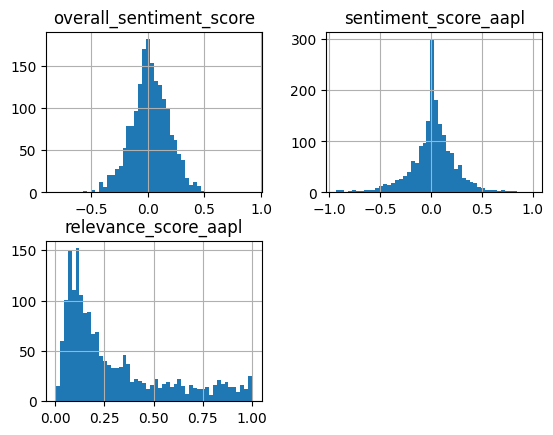

In [339]:
df.hist(column=['overall_sentiment_score', 'sentiment_score_aapl', 'relevance_score_aapl'], bins=50)

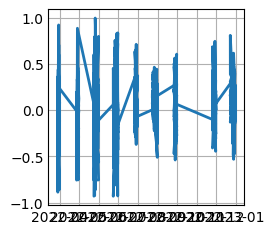

In [341]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')

# make data
x = df[['time_published']]
y = df[['sentiment_score_aapl'].]

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

plt.show()

In [340]:
df

,time_published,source,category,overall_sentiment_score,relevance_score_aapl,sentiment_score_aapl
index,,,,,,
0,2022-03-30 14:51:45,Benzinga,Trading,0.072708,0.993674,0.113538
1,2022-03-29 13:21:00,Barrons,n/a,-0.018178,0.990296,-0.018178
2,2022-03-28 14:42:12,Benzinga,News,0.011655,0.983026,0.087958
3,2022-03-30 15:38:00,Barrons,n/a,-0.209747,0.973732,-0.209747
4,2022-03-29 13:19:27,Benzinga,News,-0.027590,0.969214,-0.002274
...,...,...,...,...,...,...
1795,2022-12-23 15:52:33,Benzinga,Markets,0.002409,0.034630,-0.014457
1796,2022-12-28 16:09:53,Fox Business News,n/a,0.096829,0.031780,-0.034325
1797,2022-12-23 22:55:31,Fox Business News,n/a,0.012035,0.030878,-0.043919
